# Multi-output prediction using state-space models

## Motivation

The main motivation for this model is the use of predicted activities in an activity-based model of transportation. The aims of these models are to predict transport demand based on daily activities of people. For the purpose of this project, we are only interested in predicting the last activity, mode choice and location of a person. We managed to do predictions for the activities and the mode choice but not for the locations. A second choice that was made was the modeling choice. A state space model makes sense (of course this can be debated) from a theoretical perspective. Realization of choices of people depend on previous plans, these plans are represented by each of the hidden states and at the same time, these plans are affected by both exogenous variables such as the time of the day or the day of the week, and the plan from the last period ,i.e., the previous hidden state. 

## Data analysis and pre processing

We have two data sets which (actually) belong to a same survey: TU datas set. The TU data set is a trip survey conducted in Denmark and contains information on trips of people and some socio-economic variables. We are going to use the "Sessions.csv" data set and the the "Tur.csv" data set. The first contains the socio-economic data of the interviewees such as income, number of members in the family, municipality of origin, etc. The latter contains a travel diary for a day of this individual. The travel diary contains all the trips taken by this person on a day, when did the person made the trip, what was the purpose of it, what was the mode choice, etc.

Even though we didn't use the socio-economic variables in this project, if needed be the case, they would be selected based on "economics" intuition. This means, what are the drivers of choices of people. Some of these variables (although not an exhaustive list) are: income, municipality of residency, main occupation, etc. For the purpose of this project we only used temporal information as stated above. And interesting alley of research would be to use also socio-economic variables. 

Data pre processing was relatively easy. A random sample of 0.5% of the observations was taken from the data set. Individuals with missing values were dropped. The outcome variables were reduced in dimensionality to a dimensionality of 5 (each). 

## Model

As it has happened to me in the past, I tried to do a very complex model from the beginning. This delayed me from starting to see actual results and from noticing small details that could make the model useless. I was adviced (again) to start from a basic model and build up the complexity from there. I will outline quickly the storyline of these models (what variables I included and took away from the model) and I will explain the final model in a bit more of detail. 

Some commonalities between all the models so we don't have to repeat them on every model explanation:

    - The assumed distribution of the hidden state is a multivariate normal distribution of size HS (a hyperparameter to be defined before the model is estimated). 
    - The relation between hidden state and hidden state is a linear auto-regression of order 1. This means, the mean of the hidden state on $t$ is a linear function of inferable parameters $\beta_{hs,hs}$ and the value of the hidden state in the last-period. The hidden state is initialized with a normal distribution with mean 0 and variance-covariance matrix equal to the learned variance-covariance matrix from the model. 
    - The assumed distribution of the outcome variables is a categorical logit and the relation between the hidden state and the outcome variables (oc) is lineal on the hidden state and some inferable parameters $\beta_{hs,oc}$ of shape (HS, sizeOf(OC)). 


1. The first model is the most basic state-space model: there is a hidden state of which affects the activity.
2. What if we condition the hidden state on spatio-temporal features.
3. Take away the conditioning from the spatio-temporal features and condition the activity directly on the spatio-temporal features.
4. Take away the spatio-temporal variables. What if the hidden state of $t+1$ is affected by the activity in $t$?
5. Take away the activity affecting the hidden state. We do a hierarchical model were the intercept for each acitivty has a hyperprior for both the mean and the variance. This model was considerably better than the previous 4.
6. Use model 3 as a base and add another output to the hidden state: the mode choice. The performance of this model was poor in the sense that the model was predicting only the most common outcomes of both activity and mode choice. 
7. The last model will be explained in detail.

### Final model

The final model for this project is a state space model using the spatio-temporal variables to affect each hidden state. The length of the total number of hidden states is dynamic: we have a different length for each person. The hidden state and some infered parameters predict both the activity of the person and the mode choice. The intercept for each of the activities and mode choices is inferred for *each* observation. For more clarity, the data generation process is the following:

1. Draw global parameters from hidden state to hidden state $\beta_{hs, hs} \sim \mathcal{N}(\beta_{hs, hs} | \textbf{0}, \, 5)$
2. Draw global parameters on the variance-covariance matrix $\tau \sim \mathcal{Cauchy_{+}}(\tau | \textbf{0}, \, 5)$
3. Draw global parameters from hidden state to activity     $\beta_{hs, a} \sim \mathcal{N}(\beta_{hs, a} | \textbf{0}, \, 5)$
4. Draw global parameters from hidden state to mode choice  $\beta_{hs, mc} \sim \mathcal{N}(\beta_{hs, mc} | \textbf{0}, \, 5)$
5. For each choice (ca) in activities:
 1. Draw $\mu_{ca} \sim \mathcal{N}(\mu_{ca} | \textbf{0}, \, 5)$  # The mean hyper-prior
 2. Draw $\sigma_{ca} \sim \mathcal{Cauchy_{+}}(\sigma_{ca} | \textbf{0}, \, 5)$  # The variance hyper-prior
5. For each choice (cmc) in mode choice:
 1. Draw $\mu_{cmc} \sim \mathcal{N}(\mu_{cmc} | \textbf{0}, \, 5)$  # The mean hyper-prior
 2. Draw $\sigma_{cmc} \sim \mathcal{Cauchy_{+}}(\sigma_{cmc} | \textbf{0}, \, 5)$  # The variance hyper-prior
6. For each individual (i):
 1. Draw the initial hidden state: $\hs_{0} \sim \mathcal{N}(\hs_{0} | \textbf{0}, \, Cholesky)$

## Next steps

Some interesting directions in which I can take this model are:
- The use of socio-economic variables affecting something in the model (it is uncertain to me as they are fixed for all the periods). Probably the hyper-priors
- The implementation of non-linearities on the relations between variables and hidden-state and/or hidden state and hidden state
- The implementation of missing values imputation

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import pystan
import pystan_utils
import scipy.special # For the softmax function

# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Pandas options
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 150)

# Data loading and pre-processing

For this project we are using two datasets: the sessions data set which contains socio-economic and travel related data of people and the trip data set which contains a travel diary for a person for a day, including information related to the trip purpose, mode choice, etc.

The following tasks are done in the next section:

- [x] Load the trip (tur.csv) data set
- [x] Pick relevant features for the trip data set
- [x] Load the session (session.csv) data set
- [x] Pick relevant features from the session data set
- [x] Sample a small fraction (5%) of the total data set using 42 as a seed for speed and replication purposes
- [x] Subset both data sets using the picked relevant features
- [x] Modify the relevant features as needed: reducing dimensionality, reparametrizing, etc.

In [4]:
# Data path
data_path = '/mnt/sdb1/data_shgm/TU0616_csv/'

In [5]:
# Trips data which is going to be merged with the session dataset
trip_df = pd.read_csv(os.path.join(data_path, 'tur.csv'))

In [6]:
trip_df.shape # (429371, 74)

(429371, 74)

In [7]:
trip_df.head()

,TurId,SessionId,TurNr,TripCount,DepartHH,DepartMM,DepartMSM,ArrivalHH,ArrivalMM,ArrivalMSM,DestDwelTime,OrigNUTS,OrigMuncode,OrigOldMuncode,OrigCityCode,OrigNTMzone,OrigNearestStation,OrigDistNearestStation,DestNUTS,DestMuncode,DestOldMuncode,DestCityCode,DestNTMzone,DestNearestStation,DestDistNearestStation,OrigPurp,DestPurp,DestEscortPurp,TripPurp,TripPurpGroup,SimplWorktour,SimplWorkNumstop,GISdist,NumModes,SumLen,SumMin,SumMotorLen,SumMotorMin,ModeChainType,PrimMode,PrimModeDrivPass,SecMode,PrimModeSumlen,SecModeSumlen,FirstMode,LastMode,PartyorAlone,PartyNumu10,PartyNum1017,PartyNumAdults,BicType,CarPassDriver,CarPassContext,CarUsageCarNo,PtTicketType,PtPrice,PtBicType,PtPrimMode,PtAccMode,PtEgrMode,PtAccLen,PtEgrLen,FirstStation,LastStation,TrainMode,TrainAccMode,TrainEgrMode,TrainAccLen,TrainEgrLen,TrainAccDist,TrainEgrDist,JourneyId,JourneyRole,GISdistJourneyStartP
0,47,50026,1,1.0,9.0,30.0,570.0,10.0,25.0,625.0,605.0,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,1.0,41.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,1.0,50.8
1,48,50026,2,1.0,20.0,30.0,1230.0,21.0,25.0,1285.0,NaN,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,41.0,1.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0.0,0.0
2,49,50027,1,1.0,9.0,5.0,545.0,9.0,10.0,550.0,20.0,DK041,779.0,779.0,10791.0,779154.0,Skive ...,3.3,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,1.0,41.0,NaN,41,40,2,NaN,2.20,1.0,2.0,5.0,2.0,5.0,11.0,11.0,1.0,NaN,2.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,21.0,2.2
3,50,50027,2,1.0,9.0,30.0,570.0,9.0,40.0,580.0,35.0,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,41.0,31.0,NaN,31,30,2,NaN,2.12,1.0,3.5,10.0,3.5,10.0,11.0,11.0,1.0,NaN,3.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,1.0,2.6
4,51,50027,3,1.0,10.0,15.0,615.0,10.0,25.0,625.0,0.0,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.1,31.0,49.0,NaN,31,30,2,NaN,1.30,1.0,2.5,10.0,2.5,10.0,11.0,11.0,1.0,NaN,2.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,NaN,3.5


In [8]:
# The variables of interest from the tur dataset are:
trip_vars = [
    'SessionId',
    'TurNr',
    'PrimMode',
    'DepartMSM', 
    'OrigMuncode',
    'DestMuncode',
    'TripPurpGroup',
    'DestDwelTime'
]

In [9]:
# Subsetting of the trip data set using the variables chosen before 
trip_df  = trip_df[trip_vars]

In [10]:
# Socioeconomic dataset which is merged with the trips data, the datasets are merged using the 'SessionID' variable where the 
#  socioeconomic variables are repeated across trips
socio_df = pd.read_csv(os.path.join(data_path, 'session.csv'))

In [11]:
## The variables of interest from the session dataset are:
#   I picked these variables using pure "economic" and "transport" intuition. 
#   In the exploratory data analysis I am going to check whether this intuition solves anything
socio_vars = [
    'SessionId',
    'DiaryMonth',
    'DiaryWeekday',
    'DiaryDaytype',
    'HomeAdrMunCode',
    'RespSex',
    'RespAgeCorrect',
    'RespMainOccup',
    'RespEdulevel',
    'PrimOccMuncode',
    'RespHasBicycle',
    'RespHasSeasonticket',
    'HousehCarOwnership',
    'IncRespondent2000',
    'FamNumPers',
    'FamNumAdults', # To know if they have kids
]

In [12]:
# For speed in the training process, we use only a small fraction of the total population
socio_df = socio_df.sample(frac=0.05, random_state=42) 

In [13]:
socio_df['kids'] = socio_df.FamNumPers-socio_df.FamNumAdults
socio_df.head()

,SessionId,InterviewType,DiaryDate,DiaryYear,PseudoYear,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrNUTS,HomeAdrMunCode,HomeAdrOldMuncode,HomeAdrCityCode,HomeAdrCitySize,HomeAdrNTMzone,HomeAdrNearestStation,HomeAdrDistNearestStation,HomeParkPoss,RespSex,RespYearBorn,RespAgeSimple,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,PrimOccOldMuncode,PrimOccNTMzone,WorkHoursPw,WorkHourType,WorkPubPriv,WorkatHomeDayspM,SduMuncode,SduOldMuncode,SduNTMzone,GISdistHW,kmarbud,HwDayspW,HwDaysReason,WorkParkPoss,RespHasBicycle,RespHasSeasonticket,RespHasRejsekort,ResphasDrivlic,RespDrivlicYear,RespIsmemCarshare,HousehNumcars,HousehCarOwnership,Handicap,HousehAccomodation,HousehAccOwnorRent,IncRespondent,IncRespondent2000,IncSpouse,IncSpouse2000,IncNuclFamily,IncNuclFamily2000,IncFamily,IncFamily2000,IncHouseh,IncHouseh2000,NuclFamType,PosInFamily,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumDrivLic,DayStartNUTS,DayStartMuncode,DayStartOldMuncode,DayStartCityCode,DayStartNTMzone,DayStartJourneyRole,DayStartPurp,RespNotripReason,NightsAway,TotalNumTrips,NumTripsCorr,NumTripsExclComTrans,TotalLen,TotalLenExclComTrans,TotalMotorLen,TotalBicLen,TotalMin,TotalMotorMin,PrimModeDay,ModeChainTypeDay,DayNumJourneys,JstartType,JstartMuncode,JstartNTMzone,JstartNearestStation,JstartDistNearestStation,DayJourneyType,DayPrimTargetMuncode,DayPrimTargetPurp,SessionWeight,kids
11832,113294,2,13606,2007,2006/7,4,2,13,DK041,657,657.0,11077.0,3847.0,657213.0,Herning ...,8.0,NaN,2,1941,66,65,10.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,1.0,1959.0,2.0,1.0,1.0,2.0,1.0,1.0,100.0,87.0,150.0,131.0,250.0,218.0,250.0,218.0,250.0,218.0,20.0,11.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,DK041,657.0,657.0,11077.0,657213.0,0.0,1.0,NaN,NaN,2,2,2,230.00,230.00,230.0,0.0,276,276,11.0,11.0,1.0,2.0,657.0,657213.0,Herning ...,8.0,11,707.0,44.0,455.506948,0.0
15572,117572,2,13708,2007,2007/8,7,6,23,DK032,573,573.0,0.0,NaN,573125.0,Sig ...,4.1,NaN,1,1955,52,51,30.0,11.0,561.0,561.0,561142.0,56.0,NaN,1.0,0.0,573.0,573.0,573125.0,23.2,10.0,5.0,NaN,11.0,1.0,2,NaN,1.0,1975.0,2.0,2.0,2.0,2.0,1.0,1.0,550.0,482.0,NaN,NaN,550.0,482.0,550.0,482.0,550.0,482.0,21.0,12.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,DK032,573.0,573.0,0.0,573125.0,0.0,1.0,NaN,NaN,4,4,4,58.00,58.00,58.0,0.0,72,72,11.0,11.0,2.0,2.0,573.0,573125.0,Sig ...,4.1,11,561.0,11.0,369.105117,1.0
128334,340786,2,16565,2015,2015/16,5,7,32,DK032,540,523.0,10941.0,406.0,540335.0,Sønderborg ...,16.1,4.0,1,1982,33,33,30.0,11.0,540.0,523.0,540322.0,37.0,1.0,1.0,0.0,540.0,523.0,540335.0,7.3,NaN,5.0,NaN,11.0,1.0,2,NaN,1.0,2000.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,11.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,DK032,540.0,523.0,10941.0,540335.0,0.0,1.0,NaN,NaN,2,2,2,44.00,44.00,44.0,0.0,60,60,11.0,11.0,1.0,2.0,540.0,540335.0,Sønderborg ...,16.1,11,540.0,43.0,391.903621,1.0
97395,300923,0,15363,2012,2011/12,1,2,11,DK013,219,219.0,10808.0,1364.0,219031.0,Hillerød ...,2.8,NaN,2,1997,15,14,1.0,2.0,219.0,219.0,219062.0,NaN,NaN,NaN,NaN,219.0,219.0,219031.0,3.7,NaN,5.0,NaN,11.0,1.0,2,NaN,-18.0,NaN,NaN,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,DK013,219.0,219.0,10808.0,219031.0,0.0,1.0,NaN,NaN,5,5,5,11.89,11.89,9.5,1.0,44,20,31.0,132.0,2.0,2.0,219.0,219031.0,Hillerød ...,2.8,11,219.0,12.0,239.691289,1.0
88423,203173,2,15112,2011,2011/12,5,3,11,DK042,746,737.0,10435.0,5553.0,746033.0,Ry ...,0.7,NaN,2,1995,16,15,1.0,2.0,746.0,737.0,746033.0,NaN,NaN,NaN,NaN,746.0,737.0,746033.0,0.5,NaN,5.0,NaN,11.0,1.0,2,NaN,-18.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,DK042,746.0,737.0,10435.0,746033.0,0.0,1.0,NaN,NaN,4,4,4,2.00,2.00,1.0,1.0,8,4,11.0,21.0,2.0,2.0,746.0,746

In [14]:
# Create the kids variable
# Does the family have kids?
socio_df['kids'] = socio_df.FamNumPers-socio_df.FamNumAdults

socio_df = socio_df[socio_vars]

# Drop the (now) redundant variables
socio_df = socio_df.drop(['FamNumPers', 'FamNumAdults'], axis=1)

# Drop nans in the socio dataset after subsetting the variables. A more elegant approach would be to assume a distribution on the variables with missing values. This is left to future work
socio_df = socio_df.dropna()

# Turn variables into int type
socio_df = socio_df.astype('int')

In [15]:
# Merge the data set
df = trip_df.merge(socio_df, how='left', on='SessionId')

In [16]:
# Gets the list of session ids which have null values in any variable different from destdweltime (since all ids have nan there)
drop_idx = list(set(df.SessionId[df[set(df)-set(['DestDwelTime'])].isnull().any(axis=1)])) 
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0])).reset_index(drop=True)

In [17]:
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]
# Gets the list of session ids which have a value of 1 on the max number of trips since we are interested in modeling sequences
drop_idx = list(N_trips.SessionId[N_trips.TurNr==1])
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0]))
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]

In [18]:
# We sort the values by session id and trip number and we extract the indices of them
df.sort_values(by=['SessionId', 'TurNr'], inplace=True)
N_trips.sort_values(by='SessionId', inplace=True)
trip_idx = N_trips['TurNr'].cumsum()

In [19]:
df[list(set(df)-set(['DestDwelTime']))] = df[list(set(df)-set(['DestDwelTime']))].astype('int')

In [20]:
# Different parametrization of time so we make sure that 11:59pm is close to 12:00am
df['HH_1'] = np.sin(2*np.pi*(df.DepartMSM-180)/1440)
df['HH_2'] = np.cos(2*np.pi*(df.DepartMSM-180)/1440)

# Drop redundant variables
df = df.drop(['DepartMSM'], axis=1)

In [21]:
# Reducing the dimensionality of the dairy day type
DDT_dict = {11:'wd', 12:'we', 23:'we', 32:'we', 13:'hd', 33:'hd'}

df['DiaryDaytype'] = df['DiaryDaytype'].map(DDT_dict)

df = pd.get_dummies(df, columns=['DiaryDaytype'], prefix='DDT', drop_first=True)

In [22]:
# Interaction between day type and HH
list_ST = ['HH_1', 'HH_2', 'DDT_wd', 'DDT_we']
for hh in ['HH_1', 'HH_2']:
    for ddt in ['DDT_wd', 'DDT_we']:
        df[hh+'_'+ddt] = df[hh]*df[ddt]
        list_ST.append(hh+'_'+ddt)

In [23]:
# Reducing the dimensionality of mode choice
MC_dict = {
  **dict.fromkeys([1], 1),  # Walk
  **dict.fromkeys([2], 2),  # Bike
  **dict.fromkeys([11], 3), # Car
  **dict.fromkeys([31, 32, 33, 34], 4), # Public transport
  **dict.fromkeys([3, 4, 5, 6, 7, 12, 13, 14, 15, 25, 26, 35, 41, 42, 51], 5) # Other
} # ** is the dictionary unpacking operator, * is the list analogue. Very nice trick!

df['PrimMode'] = df['PrimMode'].map(MC_dict).astype('int')

In [24]:
df.describe()
# RespHasSeasonticket 1 yes
# RespHasBicycle      1 yes 
# RespEdulevel        1-5 high school, 6-12 vocational 13- upper education
# RespMainOccup       1-3 student, 22 30 50 52 employeed, 10 11 20 12 15 out of workforce
# DiaryDaytype        11 Mon-Thur, 12 23 32 Fri-Sun, 13 33 Holiday

,SessionId,TurNr,PrimMode,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,HH_1,HH_2,DDT_wd,DDT_we,HH_1_DDT_wd,HH_1_DDT_we,HH_2_DDT_wd,HH_2_DDT_we
count,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,9203.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,1.252500e+04,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000
mean,200641.012455,2.905230,2.635050,481.223872,481.266747,28.116647,163.573509,6.516168,3.765908,482.876567,1.508104,37.339082,23.825150,9.160639,477.416048,1.204950,1.865469,1.137006,240.640719,0.106364,-4.461422e-01,0.585150,0.381078,0.055983,0.044498,-0.244444,-0.183575
std,87958.638920,1.987234,0.941299,255.952667,256.174282,12.407932,181.282564,3.449434,1.973791,253.762771,0.499954,15.544737,13.836007,4.643338,261.081076,0.403681,0.341235,0.730047,195.073447,0.688130,5.623029e-01,0.492716,0.485671,0.531019,0.425927,0.490227,0.404984
min,50027.000000,1.000000,1.000000,101.000000,101.000000,11.000000,0.000000,1.000000,1.000000,101.000000,1.000000,7.000000,1.000000,1.000000,101.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,138919.000000,1.000000,2.000000,230.000000,230.000000,12.000000,17.000000,3.000000,2.000000,240.000000,1.000000,25.000000,3.000000,5.000000,210.000000,1.000000,2.000000,1.000000,118.000000,-0.500000,-9.396926e-01,0.000000,0.000000,-0.130526,0.000000,-0.793353,-0.382683
50%,176893.000000,2.000000,3.000000,479.000000,479.000000,30.000000,86.000000,6.000000,4.000000,479.000000,2.000000,39.000000,30.000000,11.000000,479.000000,1.000000,2.000000,1.000000,244.000000,0.130526,-7.071068e-01,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
75%,304785.000000,4.000000,3.000000,741.000000,741.000000,40.000000,273.500000,10.000000,5.000000,740.000000,2.000000,50.000000,30.000000,13.000000,746.000000,1.000000,2.000000,2.000000,317.000000,0.831470,6.123234e-17,1.000000,1.000000,0.279829,0.000000,-0.000000,0.000000
max,359787.000000,21.000000,5.000000,997.000000,997.000000,50.000000,1050.000000,12.000000,7.000000,860.000000,2.000000,82.000000,52.000000,14.000000,999.000000,2.000000,2.000000,5.000000,4088.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df.head()

,SessionId,TurNr,PrimMode,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,HH_1,HH_2,DDT_wd,DDT_we,HH_1_DDT_wd,HH_1_DDT_we,HH_2_DDT_wd,HH_2_DDT_we
0,50027,1,3,779,779,40,20.0,5,5,779,1,51,30,11,779,1,2,2,297,0.999762,-0.021815,0,0,0.0,0.0,-0.0,-0.0
1,50027,2,3,779,779,30,35.0,5,5,779,1,51,30,11,779,1,2,2,297,0.991445,-0.130526,0,0,0.0,0.0,-0.0,-0.0
2,50027,3,3,779,779,30,0.0,5,5,779,1,51,30,11,779,1,2,2,297,0.946930,-0.321439,0,0,0.0,0.0,-0.0,-0.0
3,50027,4,3,779,779,40,3.0,5,5,779,1,51,30,11,779,1,2,2,297,0.932008,-0.362438,0,0,0.0,0.0,-0.0,-0.0
4,50027,5,3,779,779,40,0.0,5,5,779,1,51,30,11,779,1,2,2,297,0.923880,-0.382683,0,0,0.0,0.0,-0.0,-0.0


In [26]:
# Tranforms the target variables into integers starting from 1
A_dict  = dict(zip(set(df.TripPurpGroup), range(1,len(set(df.TripPurpGroup))+1)))
L_dict  = dict(zip(set(df.DestMuncode), range(1,len(set(df.DestMuncode))+1)))
df['TripPurpGroup'] = df['TripPurpGroup'].map(A_dict)
df['DestMuncode']   = df['DestMuncode'].map(L_dict)

# Exploratory data analysis 

In [28]:
# In our sample of the data, leisure accounts for the most number of trips, followed by errands, wrokplace, and educational institution. Business seems to be a very small part of the total trips
df.TripPurpGroup.value_counts()

1    4269
5    3915
3    2961
4     990
2     390
Name: TripPurpGroup, dtype: int64

In [29]:
## It can be seen that car is by far the most common mode choice for our sample, followed by biking, walking and public transport. 
#   However, public transport use is not very far from the "others" category o transport choice. 
df.PrimMode.value_counts()

3    7209
2    2159
1    2013
4     674
5     470
Name: PrimMode, dtype: int64

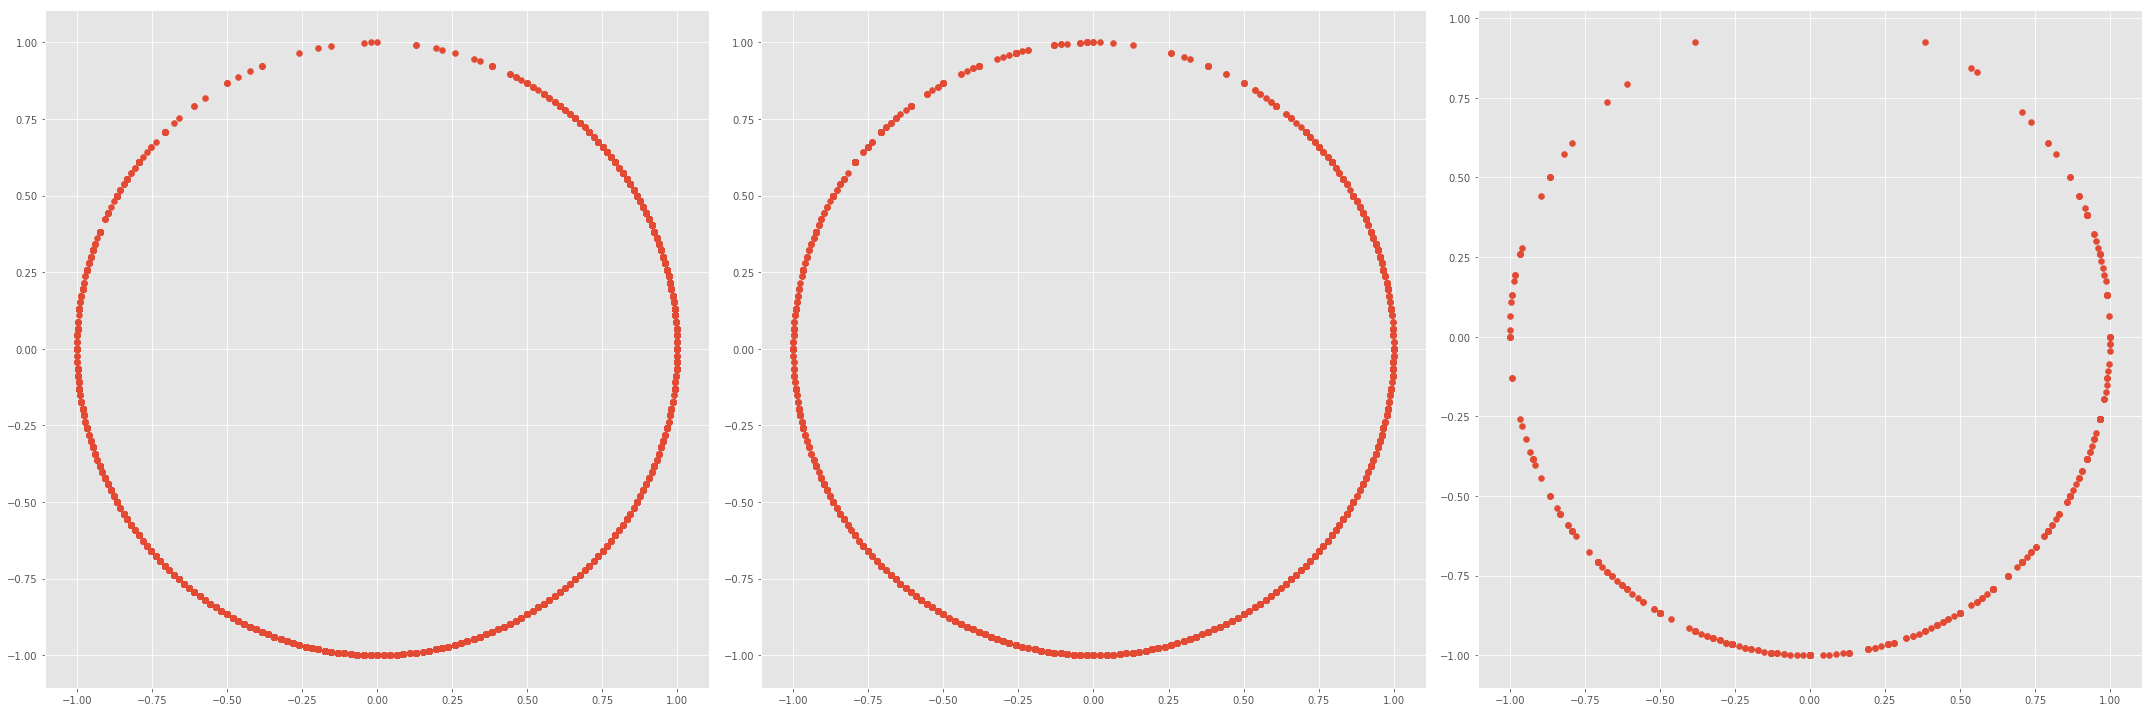

In [212]:
## After the reparametrization, we would expect to see a circle when we do a scatter plot of the time variables, if there are big gaps, we would expect to have some gaps in the time of the trips.
#  There seems to be a small gap in there, however, it is not huge. 
gridsize = (1, 3)
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

ax1.scatter(df[df['DDT_wd']==1]['HH_1'], df[df['DDT_wd']==1]['HH_2']);
ax2.scatter(df[df['DDT_we']==1]['HH_1'], df[df['DDT_we']==1]['HH_2']);
ax3.scatter(df[(df['DDT_wd']==0) & (df['DDT_we']==0)]['HH_1'], df[(df['DDT_wd']==0) & (df['DDT_we']==0)]['HH_2']);

plt.tight_layout()

In [222]:
# How does the type of day affect the purpose of the trip? 
## There are big differences in the way that weekdays and weekends affect the prupose of the trip (as we would expect). The differences are not so large for weekends and holidays
print('For weekdays: \n{}'.format(df.TripPurpGroup[df['DDT_wd']==1].value_counts()))
print('For weekends: \n{}'.format(df.TripPurpGroup[df['DDT_we']==1].value_counts()))
print('For holidays: \n{}'.format(df.TripPurpGroup[(df['DDT_we']==0) & (df['DDT_wd']==0)].value_counts()))

For weekdays: 
3    2262
5    2044
1    1909
4     801
2     313
Name: TripPurpGroup, dtype: int64
For weekends: 
1    2180
5    1697
3     638
4     189
2      69
Name: TripPurpGroup, dtype: int64
For holidays: 
1    180
5    174
3     61
2      8
Name: TripPurpGroup, dtype: int64


In [227]:
# We would also be interested in checking whether the trip purpose affects the mode choice. The idea of investigating this, is to (maybe) include the purpose of the trip as a covariate to the mode choice regression
pd.crosstab(df.TripPurpGroup, df.PrimMode, normalize='index', margins=True)

PrimMode,1,2,3,4,5
TripPurpGroup,,,,,
1,0.252284,0.151792,0.531506,0.038885,0.025533
2,0.030769,0.074359,0.520513,0.074359,0.300000
3,0.057075,0.198919,0.632557,0.076663,0.034786
4,0.176768,0.412121,0.177778,0.184848,0.048485
5,0.148148,0.123883,0.686590,0.017625,0.023755
All,0.160719,0.172375,0.575569,0.053812,0.037525


# First model, basic state-space model with activity as the predicted variable

In [279]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;      // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]  beta_hs_a;   // Weights from hidden to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_259edd1f80f0b4efba7afb40cdf624ae NOW.


In [280]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],    # Number of observations (trips)
        'N_I':  len(set(df.SessionId)), # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,# Number of hidden states
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'A':  df['TripPurpGroup'].values}     # Activities

In [281]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [282]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")

In [283]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [284]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [285]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a)+alpha_a,  axis=1), axis=1)

In [286]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS  % of accuracy
# For 5  HS  % of accuracy
# For 10 HS  % of accuracy
# For 15 HS  % of accuracy

16.75708257986739

# Second model: the hidden state is conditioned on spatio-temporal features too

In [191]:
#list_ST = ['HH_1', 'HH_2', 'DDT_wd', 'DDT_we']

In [430]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state   
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state   
    beta_hs_a[nhs,:]  ~ normal(0., 5.); // Weights from hidden to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + ST[t+1,:]*beta_st_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3465a83e14d7e5a0f7444f6d497c16a NOW.


In [431]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [432]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [433]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")

In [434]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [435]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [436]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a) + alpha_a,  axis=1), axis=1)

In [437]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS 38.30171635049684 % of accuracy
# For 5  HS 40.25895814513701 % of accuracy
# For 10 HS 44.38422161999398  % of accuracy
# For 15 HS 41.07196627521831 % of accuracy

#list_ST 2
# For 2  HS 42.81842818428184 % of accuracy
# For 5  HS 37.78982234266787 % of accuracy
# For 10 HS 45.01656127672388 % of accuracy
# For 15 HS 41.82475158084914 % of accuracy

41.82475158084914

# Third model, spatio-temporal features affecting the activity directly

In [395]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  matrix[N_ST, N_A]   beta_st_a;  // Weights from spatio-temporal to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  for (na in 1:N_A){
    beta_st_a[:,na]  ~ normal(0., 5.);  // Weights from spatio-temporal to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + ST[t,:]*beta_st_a + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc835eb9bb990d5572eac4b3145d670a NOW.


In [396]:
# Hyperparameter:
HS = 2

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [397]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [398]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")

In [399]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [400]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [401]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a)+alpha_a,  axis=1), axis=1)

In [402]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS  43.87232761216501 % of accuracy
# For 5  HS  43.87232761216501 % of accuracy
# For 10 HS  43.87232761216501 % of accuracy
# For 15 HS  43.87232761216501 % of accuracy

43.87232761216501

# Fourth model, include hidden state as a function of past activity

In [31]:
A_oh = pd.get_dummies(df, columns=['TripPurpGroup'], prefix='A', drop_first=True)[['A_2', 'A_3', 'A_4', 'A_5']].values

In [42]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Data
  matrix[N, N_A-1] A_oh; // Activities, one hot encoded
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  vector[N_A-1]       beta_a_hs;  // Weights from activities to future hidden states 
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  beta_a_hs ~ normal(0., 5.); // Weights for activities to hidden state
  alpha_a  ~ normal(0., 5.);  // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + A_oh[t,:]*beta_a_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7387a4a01f98ece14d4187e5524a4a20 NOW.


In [43]:
# Hyperparameter:
HS = 2

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'A_oh': A_oh,                       # One-hot encoded activities
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [44]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [45]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")

In [46]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [47]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [48]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a)+alpha_a,  axis=1), axis=1)

In [49]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS 66.57633242999097 % of accuracy
# For 5  HS 31.165311653116532 % of accuracy
# For 10 HS 31.105088828666066 % of accuracy
# For 15 HS 38.75338753387534 % of accuracy

66.57633242999097

# Fifth model: Hierarchical model using an individual specific intercept from hidden state to activity

In [319]:
# define Stan model with hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  
  // Hierarchical parameters for activity
  real              act_hp_mean[N_A];       // Hierarchical prior mean for activity intercept
  real<lower=0>     act_hp_var[N_A];    // Hierarchical prior sigma for activity intercept
  matrix[N_I, N_A]  alpha_a;  // Intercept for activities for each individual
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);
  
  // Alpha distribution for activity 
  for (na in 1:N_A){          
    act_hp_mean[na]    ~ normal(0,5);
    act_hp_var[na] ~ cauchy(0,5);
    
    // individual parameters (for each class)
    for (i in 1:N_I){        
      alpha_a[i, na]   ~ normal(act_hp_mean[na], act_hp_var[na]);
    }
  }

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a + alpha_a[i,:])');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_10a63fd32017c2cf61f8c7edf58e819a NOW.


In [320]:
# Hyperparameter:
HS = 10

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [321]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [322]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden",    var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a",   var_type="matrix", dims=[-1, len(set(df.TripPurpGroup))])

In [323]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [324]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [325]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a) + alpha_a,  axis=1), axis=1)

In [326]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS   60.19271303824149  % of accuracy
# For 5  HS   60.584161397169524 % of accuracy
# For 10 HS   59.95182174043963  % of accuracy
# For 15 HS   60.85516410719663  % of accuracy

59.95182174043963

# Sixth model: Add mode choice as a second predicted variable, using model 3 as a base.
First add it by itself and maybe in model 7 we add it as a function of both hidden state and activity

In [65]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_MC; // Number of mode choices
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
  int  MC[N]; // Mode choice
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  matrix[N_HS, N_MC]   beta_hs_mc;  // Weights from hidden to activities
  
  vector[N_A]   alpha_a;  // Intercept for activities
  vector[N_MC]  alpha_mc; // Intercept for mode choice
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state   
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state   
    beta_hs_a[nhs,:]  ~ normal(0., 5.); // Weights from hidden to activities
    beta_hs_mc[nhs,:] ~ normal(0., 5.); // Weights from hidden to mode choice
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  alpha_mc ~ normal(0., 5.); // Intercepts for mode choice
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + ST[t+1,:]*beta_st_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a')');
      MC[t] ~ categorical_logit((hidden[t,:]*beta_hs_mc + alpha_mc')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8f6fdf811bdd3ea4fef37024e64cf23 NOW.


In [66]:
# Hyperparameter:
HS = 10

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_MC': len(set(df.PrimMode)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values,   # Activities
        'MC': df['PrimMode'].values}   # Mode choice

In [ ]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [ ]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
beta_hs_mc    = pystan_utils.vb_extract_variable(fit, "beta_hs_mc", var_type="matrix", dims=[HS, len(set(df.PrimMode))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")
alpha_mc      = pystan_utils.vb_extract_variable(fit, "alpha_mc", var_type="vector")

In [ ]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [ ]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_MC   = df['PrimMode'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [ ]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a) +alpha_a,  axis=1), axis=1)
pred_MC = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_mc)+alpha_mc, axis=1), axis=1)

In [73]:
print('The accuracy for activities is: {}'.format(np.sum(last_A == pred_A)*100/len(last_A))) 
print('The accuracy for mode choice is: {}'.format(np.sum(last_MC == pred_MC)*100/len(last_MC))) 
# ACTIVITY
# For 2  HS  34.808792532369765 % of accuracy
# For 5  HS  34.507678410117435 % of accuracy
# For 10 HS  41.01174345076784 % of accuracy
# For 15 HS  41.58386028304727 % of accuracy

# MODE CHOICE
# For 2  HS  58.44625112917796 % of accuracy
# For 5  HS  58.44625112917796 % of accuracy
# For 10 HS  58.44625112917796 % of accuracy
# For 15 HS  58.44625112917796 % of accuracy

The accuracy for activities is: 41.01174345076784
The accuracy for mode choice is: 58.44625112917796


# Seventh model: spatio-temporal features affecting the hidden state and hyper priors for the intercepts of both mode choice and activity

In [153]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_MC; // Number of mode choices
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
  int  MC[N]; // Mode choice
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  matrix[N_HS, N_MC]  beta_hs_mc;  // Weights from hidden to activities
  
  vector[N_A]           act_hp_mean; //
  vector<lower=0>[N_A]  act_hp_var; //
  vector[N_MC]          mc_hp_mean; //
  vector<lower=0>[N_MC] mc_hp_var; //
  
  matrix[N_I, N_A]   alpha_a;  // Intercept for activities
  matrix[N_I, N_MC]  alpha_mc; // Intercept for mode choice
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state   
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state   
    beta_hs_a[nhs,:]  ~ normal(0., 5.); // Weights from hidden to activities
    beta_hs_mc[nhs,:] ~ normal(0., 5.); // Weights from hidden to mode choice
  }
  
  // Alpha distribution for activity 
  for (na in 1:N_A){          
    act_hp_mean[na]    ~ normal(0,5);
    act_hp_var[na] ~ cauchy(0,5);
    
    // individual parameters (for each class)
    for (i in 1:N_I){        
      alpha_a[i, na]   ~ normal(act_hp_mean[na], act_hp_var[na]);
    }
  }
  
  // Alpha distribution for mode choice 
  for (nmc in 1:N_MC){          
    mc_hp_mean[nmc] ~ normal(0,5);
    mc_hp_var[nmc]  ~ cauchy(0,5);
    
    // individual parameters (for each class)
    for (i in 1:N_I){        
      alpha_mc[i, nmc]   ~ normal(mc_hp_mean[nmc], mc_hp_var[nmc]);
    }
  }
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + ST[t+1,:]*beta_st_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a[i,:])');
      MC[t] ~ categorical_logit((hidden[t,:]*beta_hs_mc + alpha_mc[i,:])');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e67cf5c551a69919d6b5cca3fd16de6a NOW.


In [154]:
# Hyperparameter:
HS = 2

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_MC': len(set(df.PrimMode)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values,   # Activities
        'MC': df['PrimMode'].values}   # Mode choice

In [133]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [134]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a     = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])
beta_hs_mc    = pystan_utils.vb_extract_variable(fit, "beta_hs_mc", var_type="matrix", dims=[HS, len(set(df.PrimMode))])
alpha_a       = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="matrix", dims=[-1, len(set(df.TripPurpGroup))])
alpha_mc      = pystan_utils.vb_extract_variable(fit, "alpha_mc", var_type="matrix", dims=[-1, len(set(df.PrimMode))])

In [ ]:
fit = sm.sampling(data=data, iter=1000, chains=3, algorithm="NUTS", seed=42, verbose=True)
#fit['hidden'] # Extracts the hidden states

In [135]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [185]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_MC   = df['PrimMode'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [186]:
pred_A  = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a) +alpha_a,  axis=1), axis=1)
pred_MC = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_mc)+alpha_mc, axis=1), axis=1)

In [187]:
print('The accuracy for activities is: {}'.format(np.sum(last_A == pred_A)*100/len(last_A))) 
print('The accuracy for mode choice is: {}'.format(np.sum(last_MC == pred_MC)*100/len(last_MC))) 
# ACTIVITY
# For 2  HS  63.535079795242396 % of accuracy
# For 5  HS  60.88527551942186 % of accuracy
# For 10 HS  64.19753086419753 % of accuracy
# For 15 HS  61.75850647395363 % of accuracy

# MODE CHOICE
# For 2  HS  78.71123155676001 % of accuracy
# For 5  HS  76.24209575429087 % of accuracy
# For 10 HS  75.06775067750678 % of accuracy
# For 15 HS  75.24841915085817 % of accuracy

The accuracy for activities is: 63.535079795242396
The accuracy for mode choice is: 78.71123155676001


In [180]:
first_trip = np.concatenate(([0], trip_idx.values+1))[:-1]
first_hs   = hidden_states[first_trip-1, :]

In [170]:
hidden_states.shape

(12525, 2)

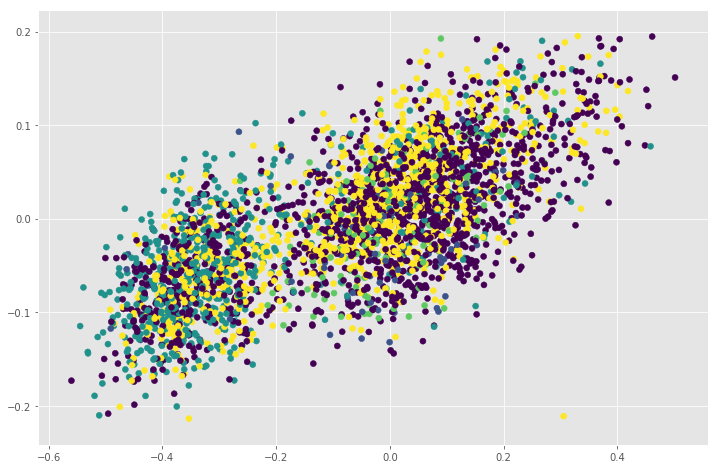

In [183]:
plt.scatter(first_hs[:,0], first_hs[:,1], c=last_A);

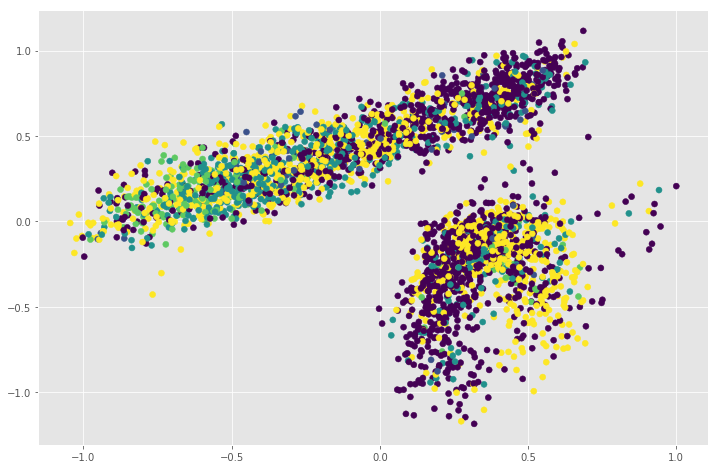

In [184]:
plt.scatter(last_hs[:,0], last_hs[:,1], c=last_A);

In [ ]:
plt.scatter(last_hs[:,0], last_hs[:,1], c=last_MC);

In [159]:
samples = fit.extract()

In [164]:
a_hp_mean = samples['act_hp_mean']
a_hp_sig = samples['act_hp_var']

In [161]:
a_hp_mean.shape

(1500, 5)

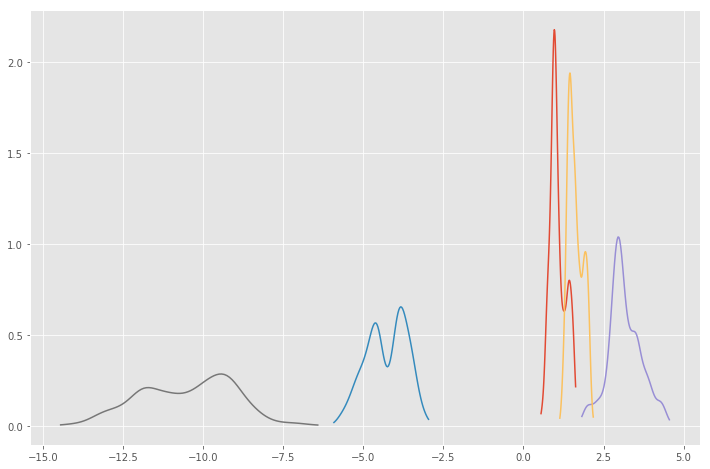

In [163]:
pystan_utils.plot_kde(a_hp_mean)

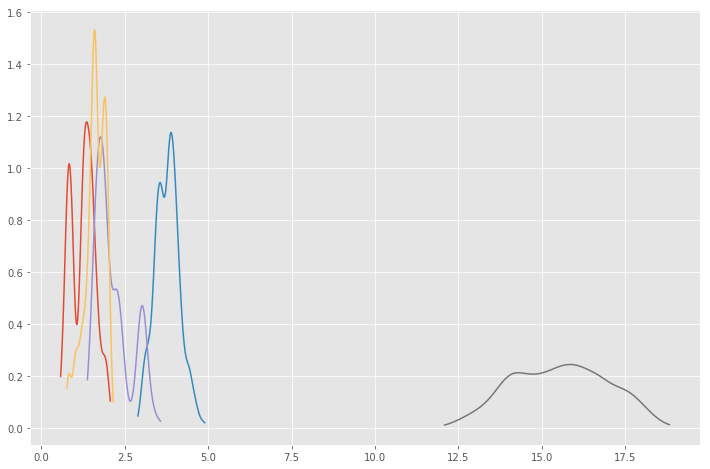

In [165]:
pystan_utils.plot_kde(a_hp_sig)

In [ ]:
pystan_utils.vb_plot_variables(fit, 'alpha_a');

In [144]:
last_hs.shape

(3321, 2)

During these three days I have to work on the following (for the jupyter notebook):
Sketch all the models I runned and include them in the notebook
Explore a bit the interest variables (activity and location) and how they relate to other variables
Write down what is the intuition behind the choices in the models
Re-factor the code if needed
Write down the generative process of the final model

(For the paper):
Write down the final model and the process of creating it.
Write down the challenges of creating the model 
Write down the results and possible extensions

In [121]:
list_ST = ['OrigMuncode', 'DiaryMonth', 'DiaryWeekday', 'DiaryDaytype', 'HH_1', 'HH_2']
list_SE = ['HomeAdrMunCode', 'RespSex', 'RespAgeCorrect', 'RespMainOccup', 'RespEdulevel', 'PrimOccMuncode', 'RespHasBicycle', 'RespHasSeasonticket', 'HousehCarOwnership', 'IncRespondent2000', 'kids']